In [31]:
import torch
import torch.nn as nn
from collections import Counter
from matplotlib import pyplot as plt
from tqdm import tqdm
import re
import heapq
from queue import Queue
import time



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# 输入的文本
text = """People who truly loved once are far more likely to love again.
Difficult circumstances serve as a textbook of life for people.
The best preparation for tomorrow is doing your best today.
The reason why a great man is great is that he resolves to be a great man.
The shortest way to do many things is to only one thing at a time.
Only they who fulfill their duties in everyday matters will fulfill them on great occasions.
I go all out to deal with the ordinary life.
I can stand up once again on my own.
Never underestimate your power to change yourself."""
text = text + text

In [33]:

def processText(text):
    text = text.lower()
    remove_chars = '[·’!"\#$%&\'()＃！（）*+,-./:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+' # 去除标点符号
    text= re.sub(remove_chars, "", text)
    text = text.split()
    return text

text = processText(text)


In [34]:

# 输入是1*V的矩阵，V是词汇表的大小
EMDEDDING_DIM = 100  # 词向量维度, 词向量的维度一般是50, 100, 200, 300维, 是矩阵的列数

word = set(text) #
word_size = len(word) # 词汇表的大小

Words_Loss = [0 for i in range(word_size)]
Words_Process_Loss = [[] for i in range(word_size)]

# 有了这两个映射，我们才能通过输出层预测结果
word_to_ix = {word: ix for ix, word in enumerate(word)}
ix_to_word = {ix: word for ix, word in enumerate(word)}


In [35]:

# Huffman tree node class
class HuffmanNode:
    def __init__(self, freq, token=None, left_child=None, right_child=None, embed_dim=0, wordsize=0):
        self.embed_dim = embed_dim  # 词向量维度
        self.code = None
        self.freq = freq
        self.token = token
        self.thetas = [(torch.randn(self.embed_dim, 1,requires_grad=True)).to(device) for _ in range(wordsize)]  # 每个节点都有对应wordsize个词向量的theta，theta的大小是 embed_dim * 1

        self.left_child = left_child
        self.right_child = right_child

    def __lt__(self, other):
        return self.freq < other.freq


# Huffman tree class
class HuffmanTree:
    def __init__(self, tokens_freqs, embed_dim, wordsize):
        self.decoder = None
        self.encoder = None
        self.embed_dim = embed_dim
        self.wordsize = wordsize
        self.nodes = []
        self.token2node = {} # 单词到node的映射

        for token, freq in tokens_freqs.items():
            node = HuffmanNode(freq, token, embed_dim=self.embed_dim, wordsize=self.wordsize)
            heapq.heappush(self.nodes, node)  # Push the node into the heap
            self.token2node[token] = node

        while len(self.nodes) > 1:
            node1 = heapq.heappop(self.nodes)
            node2 = heapq.heappop(self.nodes)
            new_node = HuffmanNode(node1.freq + node2.freq, None, node1, node2, embed_dim=self.embed_dim,
                                   wordsize=self.wordsize)
            heapq.heappush(self.nodes, new_node)

        self.root = self.nodes[-1]  # The last node in the heap is the root of the Huffman tree

    # Traversing the Huffman Tree and generating codes for each token
    def generate_codes(self, node=None, code=''):
        if node is None:
            node = heapq.heappop(self.nodes)

        if node.token is not None:
            self.token2node[node.token].code = code
            return [(node.token, code)]

        codes = []
        if node.left_child:
            codes.extend(self.generate_codes(node.left_child, code + '1'))
        if node.right_child:
            codes.extend(self.generate_codes(node.right_child, code + '0'))

        return codes

In [36]:
class Ada_Node:
    def __init__(self, freq = 1,token = None, left_child = None, right_child = None, embed_dim = 0, wordsize = 0):
        
        self.weight = 0
        self.code = None
        self.embed_dim = embed_dim
        self.thetas = [(torch.randn(self.embed_dim, 1,requires_grad=True)).to(device) for _ in range(wordsize)]  # 每个节点都有对应wordsize个词向量的theta，theta的大小是 embed_dim * 1
        
    

        self.parent = None
        self.right_child = left_child
        self.left_child = right_child
        
        self.level = 0
        if token == None:
            self.char = b'*'
        else:
            self.char = token


    # 设置该节点的左孩子为node
    def setLeft(self, node):
        self.left_child = node
        node.parent = self
        node.updateLevel()


    # 设置该节点的右孩子为node
    def setRight(self, node):
        self.right_child = node
        node.parent = self
        node.updateLevel()

    # 把该节点为child的孩子节点换成node
    def replaceChild(self, child, node):
        if self.left_child == child:
            self.setLeft(node)
        elif self.right_child == child:
            self.setRight(node)

    # 更新该节点所在子树的level
    def updateLevel(self):
        self.level = self.parent.level+1
        if self.right_child:
            self.right_child.updateLevel()
        if self.left_child:
            self.left_child.updateLevel()


    # 该节点没有孩子
    def hasNoChild(self):
        return self.left_child == None and self.right_child == None

    # node是该节点的祖先
    def isAncestor(self, node):
        ancestor = self.parent
        while ancestor:
            if ancestor == node:
                return True
            ancestor = ancestor.parent
        return False

    # 交换该节点与node的位置
    def swap(self, node):
        if self == node or node.isAncestor(self) or self.isAncestor(node):
            return
        parent1 = self.parent
        parent2 = node.parent
        parent2.replaceChild(node, self)
        parent1.replaceChild(self, node)




class Ada_HuffmanTree:
    def __init__(self, embed_dim, word_size):
        self.root = Ada_Node(embed_dim=embed_dim,wordsize=word_size)
        self.token2node = {}
        self.emptyNode = self.root
        self.decoder = None
        self.embed_dim = embed_dim
        self.word_size =word_size
        

        self.counter = 0

    def exist(self, token):
        return token in self.token2node

    def addChar(self, token):
        node = Ada_Node(token = token,embed_dim=self.embed_dim,wordsize=self.word_size)
        self.token2node[token] = node
        self.emptyNode.setLeft(Ada_Node(embed_dim=self.embed_dim,wordsize=self.word_size))
        self.emptyNode.setRight(node)
        self.emptyNode = self.emptyNode.left_child

    def addTokens(self,tokens_freqs):
        for token, freq in tokens_freqs.items():
            for i in range(freq):
                if not self.exist(token):
                    self.addChar(token)
                self.updateTree(self.token2node[token])
    
    def generate_codes(self):
        codes = []
        for token in self.token2node.keys() :
            codes.append((token,self.huffmanCode(self.token2node[token]))) 
            self.token2node[token].code = self.huffmanCode(self.token2node[token])
        return codes

            

    

    def endOfFile(self):
        return self.huffmanCode(self.emptyNode)

    def huffmanCode(self, node):
        code = ''
        if node == self.root:
            return '0'
        parent = node.parent
        while parent:
            if parent.left_child == node:
                code += '1'
            else:
                code += '0'
            node = parent
            parent = node.parent

        return code[::-1]  # reverse
    

    # 找到权重为weight最远的节点（即最右边的，也就是最小的，因为我们这里是以右边为0），用于替换
    def findFarthestNode(self, weight):
        q = Queue()
        q.put(self.root)
        while not q.empty():
            node = q.get()
            if node.weight == weight:
                return node
            if node.right_child:
                q.put(node.right_child)
            if node.left_child:
                q.put(node.left_child)

    def updateTree(self, node):
        while node:
            node.swap(self.findFarthestNode(node.weight))
            node.weight += 1
            node = node.parent



    def reHuffmanCode(self, file):
        if self.root.hasNoChild():
            file.read(1)
            return self.root

        node = self.root
        while not node.hasNoChild():
            ch = file.read(1)
            if ch == '1':
                node = node.right_child
            elif ch == '0':
                node = node.left_child
            else:
                return self.emptyNode

        return node

    def printTree(self):
        print('------tree------')
        q = Queue()
        q.put(self.root)
        level = 0
        while not q.empty():
            node = q.get()
            if node.level > level:
                level = node.level
                print()
            print('%s:%s' % (node.weight, str(node.char)), end=' ')
            if node.left:
                q.put(node.left_child)
            if node.right:
                q.put(node.right_child)
        print('\n')

In [37]:
# 定义一个函数，把文本转换成索引的形式
def make_context_vector(context, word_to_ix): # context是上下文单词列表，word_to_ix是单词到索引的映射
    idxs = [word_to_ix[w] for w in context] # 将上下文单词转换成索引的形式
    res = torch.tensor(idxs, dtype=torch.long)  
    return  res # 返回的是tensor

In [38]:
# 定义训练数据
data = [] # 定义一个列表，用来存储训练数据
for i in range(2, len(text) - 2):
    context = [text[i - 2], text[i - 1], # 根据上下文预测目标词汇，窗口大小为4
               text[i + 1], text[i + 2]]
    target = text[i]
    data.append((context, target))


In [39]:
tokens_freqs = Counter(text) # 得到文章中每个单词出现的次数
# tree = HuffmanTree(tokens_freqs,EMDEDDING_DIM,word_size)
tree = Ada_HuffmanTree(embed_dim= EMDEDDING_DIM,word_size=word_size)
tree.addTokens(tokens_freqs)

huffman_codes = tree.generate_codes()
decoder = {code: token for token, code in huffman_codes}
vocab_size = len(tokens_freqs)

In [40]:
class MyOptimizer():
    def __init__(self, thetas, x_w, embedding, context_vector, code, lr = 0.01):
        # thetas就是当前单词的Huffman路径上每个节点的theta向量；embedding是词向量构成的矩阵；context_vector；code是这个单词的huffman编码；lr是学习率；context_vector是上下文单词的索引,长度为4
        self.lr = lr
        self.code = code
        self.thetas = thetas,
        self.x_w = x_w
        self.context_vector = context_vector
        self.embedding = embedding # 词向量矩阵

    def step(self):

        for i in range(len(self.thetas[0])): # thetas[0]才是单层列表
            d_jw = torch.tensor(int(self.code[i])) # 当前单词w的huffman路径上的第j个码字，也就是w对应的code里的第j位
            theta_grad = (1-d_jw-torch.sigmoid(self.x_w.matmul(self.thetas[0][i]))) * self.x_w # theta的梯度
            self.thetas[0][i] = self.thetas[0][i] + theta_grad.T * self.lr # 更新 theta的梯度
        # 以下更新方式见下面的算法
        e = 0
    
        for i in range(len(self.thetas[0])):
            d_jw = torch.tensor(int(code[i]))
            q = torch.sigmoid(self.x_w.matmul(self.thetas[0][i]))
            g = self.lr * (1-d_jw-q)
            e = e + g * self.thetas[0][i]
            self.thetas[0][i] = self.thetas[0][i]+ g*self.x_w
        e = torch.squeeze(e,1)
        with torch.no_grad():
            for k in self.context_vector:
                self.embedding[k] = self.embedding[k] + e

![gradient.png](https://obsidian-1317758465.cos.ap-shanghai.myqcloud.com/images/gradient.png)

In [41]:

# CBOW model with hierarchical softmax optimization
class CBOWHierarchicalSoftmax(nn.Module):
    def __init__(self, word_size, embedding_dim, huffman_tree):
        super(CBOWHierarchicalSoftmax, self).__init__()

        self.embeddings = nn.Embedding(word_size, embedding_dim).to(device) # 定义词向量矩阵
        self.thetas = [] # 定义当前word的所有theta
        self.x_w = torch.randn(embedding_dim,1) # 定义x_w, 也就是当前word的上下文词向量求和

        self.huffman_tree = huffman_tree


    def loss_f(self, context_vector, target):
        self.x_w = sum(self.embeddings(context_vector)).view(1, -1) # 将上下文词向量求和，然后转换成1*V的形式

        self.x_w.to(device) # 将x_w放到GPU上
        token = target
        code = self.huffman_tree.token2node[token].code
        node = self.huffman_tree.root

        Loss = 0

        self.thetas = []
        # print(word_to_ix[target])
        # print(len(node.thetas))
        # print(node.thetas[word_to_ix[target]])
        for j, d in enumerate(code):
            # print(word_to_ix[target])
            # print(len(node.thetas))

            self.thetas.append(node.thetas[word_to_ix[target]]) # 将当前word的所有theta存储起来
            if d == '1':
                node = node.left_child
            else:
                node = node.right_child

        for j in range(len(code)):
            d_jw = torch.tensor(int(code[j])) #
            t = torch.log(torch.sigmoid(self.x_w.matmul(self.thetas[j])))
            # print("在{}的loss_f函数的第{}轮中".format(target,j))
            #
            # print("d_jw is {} | torch.log is {}".format(d_jw,t))

            Loss += (1-d_jw) * t + d_jw * (1-t)

        Words_Loss[word_to_ix[target]] = Loss

        Words_Process_Loss[word_to_ix[target]].append(Loss)
        return Loss

    def forward(self, context_vector): # 预测的方式可能还有问题？
        x_w = sum(self.embeddings(context_vector)).view(1, -1) # 将上下文词向量求和，然后转换成1*V的形式

        node = self.huffman_tree.root
        while node is not None:
            if node.left_child is None and node.right_child is None: # 如果是叶子节点，就返回
                break
            else:
                if x_w.matmul(node.thetas[word_to_ix[target]]) < 0: # 如果x_w * theta < 0, 就往左走
                    node = node.left_child
                else:
                    node = node.right_child
        code = node.code

        res_toke = decoder[code]
        res_ix = word_to_ix[res_toke]
        return res_ix, res_toke # 返回的是预测的目标词的下标和词

In [42]:
# 初始化一个模型
cbow_model = CBOWHierarchicalSoftmax(vocab_size, EMDEDDING_DIM, tree)


In [43]:
# 模型训练
t0 = time.time()
epochs = tqdm(range(100))
for epoch in epochs:
     for context, target in data:
        epochs.set_postfix(target = target, loss = Words_Loss[word_to_ix[target]])
        # 梯度清零
        cbow_model.zero_grad()
        # 这里的向量长度为4，因为我们的窗口就是上下2个单词
        context_vector = make_context_vector(context, word_to_ix)
        # 损失函数
        loss = cbow_model.loss_f(context_vector, target)
        # loss.backward()
        code = cbow_model.huffman_tree.token2node[target].code
        cbow_model.x_w.to(device) # 将x_w放到GPU上
        optimizer = MyOptimizer(cbow_model.thetas,cbow_model.x_w,cbow_model.embeddings.weight, context_vector,code)
        optimizer.step()
        # prediction_ix, prediction_token = cbow_model(context_vector)
t1 = time.time()
print(f'训练时间: {t1-t0}s\n')


100%|██████████| 100/100 [00:47<00:00,  2.11it/s, loss=tensor([[46.7677]], grad_fn=<AddBackward0>), target=to]           

训练时间: 47.462007999420166s



In [44]:
# 预测
correct_rate = 0
t0 = time.time()
for context, target in data:
    print(context, target)
    context_vector = make_context_vector(context, word_to_ix)
    prediction_ix, prediction_token = cbow_model(context_vector)
    if prediction_token == target:
        correct_rate += 1
    print(f'预测: {context}\n')
    print(f'预测结果: {prediction_token}\n')
    print(f'预测结果: {prediction_token}\n')
    print(f'真实结果: {target}\n')
    print('\n')
t1 = time.time()
print(f'预测时间: {t1-t0}s\n')
print(f'正确率: {correct_rate/len(data) * 100}%\n')

context1 = ['people', 'who', 'loved', 'once']
context_vector1 = make_context_vector(context1, word_to_ix)
a_i,a = cbow_model(context_vector1)


['people', 'who', 'loved', 'once'] truly
预测: ['people', 'who', 'loved', 'once']

预测结果: truly

预测结果: truly

真实结果: truly



['who', 'truly', 'once', 'are'] loved
预测: ['who', 'truly', 'once', 'are']

预测结果: loved

预测结果: loved

真实结果: loved



['truly', 'loved', 'are', 'far'] once
预测: ['truly', 'loved', 'are', 'far']

预测结果: once

预测结果: once

真实结果: once



['loved', 'once', 'far', 'more'] are
预测: ['loved', 'once', 'far', 'more']

预测结果: are

预测结果: are

真实结果: are



['once', 'are', 'more', 'likely'] far
预测: ['once', 'are', 'more', 'likely']

预测结果: far

预测结果: far

真实结果: far



['are', 'far', 'likely', 'to'] more
预测: ['are', 'far', 'likely', 'to']

预测结果: more

预测结果: more

真实结果: more



['far', 'more', 'to', 'love'] likely
预测: ['far', 'more', 'to', 'love']

预测结果: likely

预测结果: likely

真实结果: likely



['more', 'likely', 'love', 'again'] to
预测: ['more', 'likely', 'love', 'again']

预测结果: to

预测结果: to

真实结果: to



['likely', 'to', 'again', 'difficult'] love
预测: ['likely', 'to', 'again', 'difficult']



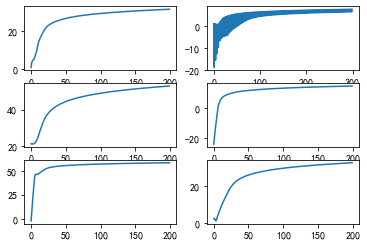

In [45]:
fig, axes = plt.subplots(3, 2)
for i in range(axes.shape[0]):
    d = [torch.squeeze(x,0).detach().numpy() for x in Words_Process_Loss[2*i]]
    D = [x[0] for x in d]
    axes[i, 0].plot(D)

    d = [torch.squeeze(x,0).detach().numpy() for x in Words_Process_Loss[2*i+1]]
    D = [x[0] for x in d]
    axes[i, 1].plot(D)

